<a href="https://colab.research.google.com/github/nalrob/Procesamiento_de_datos/blob/main/Practica2_PCD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Practica 2**

Dependiendo del tipo de datos que Uds. estén manejando para su proyecto, van a realizar un análisis inicial de sus datos. Justifiquen el uso de ellos, y como están orientados a resolver su problemática propuesta.

## Problematica

Entre los problemas ambientales generados por el calientamiento global estan los incendios forestales en zonas boscosas durante el verano. Me gustaria explorar con este proyecto, el generar un mecanismo de acción que sea capaz de detectar el inicio del fuego a distancia para así lograr mitigarlo a tiempo.

## Descripción del dataset

Fuente: Kaggle

Fue creado durante el NASA Space Apps Challenge en 2018, con el objetivode utilizar el conjunto de datos para desarrollar un modelo que pueda reconocer las imágenes con fuego.

Los datos se dividen en 2 carpetas, la carpeta fire_images contiene 755 imágenes de incendios al aire libre, algunas de ellas contienen humo denso, la otra es non-fire_images que contiene 244 imágenes de la naturaleza (por ejemplo: bosque, árbol, hierba, río, personas, bosque de niebla, lago, animal, camino y cascada).

Estas carpetas son comprimidas y despues descomprimidas para su importación. Posteriormente se genera un dataset de imágenes en clasificacion binaria con las catacteristicas antes mencionadas.


## Importacion de los datos

In [1]:
from google.colab import files
uploaded= files.upload()

Saving images_zip.zip to images_zip.zip


In [2]:
!pwd

/content


In [3]:
import zipfile
import io
data =zipfile.ZipFile(io.BytesIO(uploaded['images_zip.zip']),'r')
data.extractall()

In [4]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import StratifiedShuffleSplit

sns.set_style('darkgrid')

In [5]:
#create an empty DataFrame
df = pd.DataFrame(columns=['path','label'])

#loop over fire images and label them 1
for dirname, _, filenames in os.walk('/content/fire_images'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))

#loop over non fire images and label them 0
for dirname, _, filenames in os.walk('/content/non_fire_images'):
    for filename in filenames:
        df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'non_fire']],columns=['path','label']))

#shuffle the dataset for redistribute the labels
df = df.sample(frac=1).reset_index(drop=True)

<ipython-input-5-7fe623c2995b>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
<ipython-input-5-7fe623c2995b>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
<ipython-input-5-7fe623c2995b>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[os.path.join(dirname, filename),'fire']],columns=['path','label']))
<ipython-input-5-7fe623c2995b>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame([[

## Muestreo estraficado

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

labels = df['label']

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)


num_samples_per_category = 100
sampled_indices = []

for train_index, test_index in sss.split(df, labels):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]

    for label in df['label'].unique():
        label_indices = test_df[test_df['label'] == label].index
        sampled_indices.extend(label_indices[:num_samples_per_category])

sampled_test_df = df.loc[sampled_indices]


print(sampled_test_df.head(10))


                                  path label
538    /content/fire_images/fire.7.png  fire
325  /content/fire_images/fire.152.png  fire
156   /content/fire_images/fire.90.png  fire
233  /content/fire_images/fire.272.png  fire
291  /content/fire_images/fire.110.png  fire
99    /content/fire_images/fire.29.png  fire
284  /content/fire_images/fire.324.png  fire
366   /content/fire_images/fire.27.png  fire
140  /content/fire_images/fire.247.png  fire
441   /content/fire_images/fire.47.png  fire


## Analisis descriptivo

In [7]:
fig = px.scatter(data_frame = df,x=df.index,y='label',color='label',title='Distribution of fire and non-fire images along the length of the dataframe')
fig.update_traces(marker_size=2)

In [8]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])


fig.add_trace(go.Bar(x =df['label'].value_counts().index,y=df['label'].value_counts().to_numpy(),marker_color=['darkorange','green'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(
     values=df['label'].value_counts().to_numpy(),
     labels=df['label'].value_counts().index,
    marker=dict(colors=['darkorange','green'])),
    row=1, col=2)

In [9]:
def shaper(row):
    shape = image.load_img(row['path']).size
    row['height'] = shape[1]
    row['width'] = shape[0]
    return row
df = df.apply(shaper,axis=1)
df.head(5)

,path,label,height,width
0,/content/fire_images/fire.218.png,fire,313,470
1,/content/fire_images/fire.124.png,fire,541,1000
2,/content/fire_images/fire.278.png,fire,225,400
3,/content/fire_images/fire.261.png,fire,805,1200
4,/content/fire_images/fire.196.png,fire,456,810


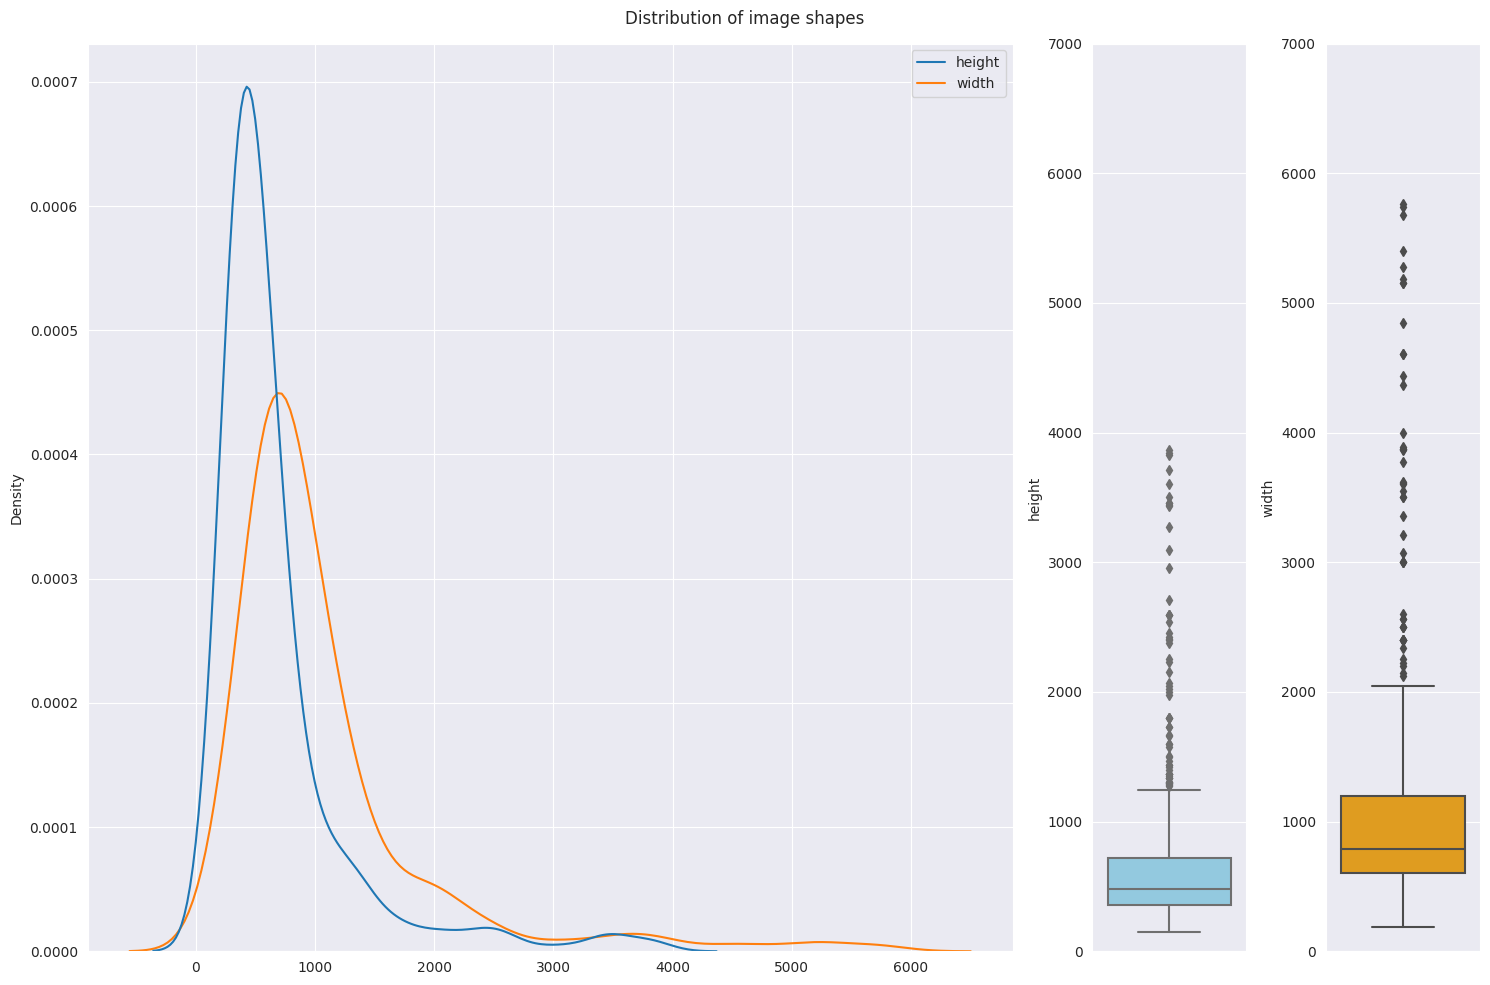

In [10]:
sns.set_style('darkgrid')
fig,(ax1,ax2,ax3) = plt.subplots(1,3,gridspec_kw={'width_ratios': [3,0.5,0.5]},figsize=(15,10))
sns.kdeplot(data=df.drop(columns=['path','label']),ax=ax1,legend=True)
sns.boxplot(data=df,y='height',ax=ax2,color='skyblue')
sns.boxplot(data=df,y='width',ax=ax3,color='orange')
plt.suptitle('Distribution of image shapes')
ax3.set_ylim(0,7000)
ax2.set_ylim(0,7000)
plt.tight_layout()